# Data Analytics for MOOC Providers

#### Created by [Miguel Ballesteros](mailto:mabm1e15@soton.ac.uk)

### *Notebook list*
1. [Introduction](index.ipynb)
2. [The Downloaded CSV Files](downloaded_data.ipynb)
3. [Data Processing Pipeline](data_pipeline.ipynb)
4. **[Clean Data Exploration](clean_data_exploration.ipynb)**
5. [Understanding MOOC behaviors](understanding_mooc.ipynb)
6. [Predicting Dropouts](predicting_dropouts)
7. [Conclusions](conclusions.ipynb)
8. [Future Work](future_work.ipynb)

### *In this notebook...*
1. [Exploration Goal](#Exploration-Goal)
2. [Data Load](#Data-Load)
3. [Course Data Frames](#Course-Data-Frames)
4. [Enrolments Data Frame](#Enrolments-Data-Frame)
5. [Step Activity Data Frame](#Step-Activity-Data-Frame)

## Exploration Goal

Within this notebook the cleaned data is explored with the aim to determine the possible transformations to use in later models. The cleaned data is basically the raw data after removing invalid entries and converting all columns to the right data types.

The task starts by loading the cleaned data from the RData file saved in the folder Data_Clean using the same methods defined for the pipeline processing. Then the data frames are listed. When using the default values, those are identified with the prefix "df_".

## Data Load

In [19]:
source("00_config.r")              # R file with global configuration values
source("02_clean.r")               # R file with clean-related functions
load_clean_data_file(DATA_CLEAN)   # Loads the preprocessed clean data. Uses the globally defined variable DATA_CLEAN.
summary_clean_data()               # Table summarizing the number of records per data frame, grouped by the short course name

[1] "INFO - START - load_clean_data_file"
[1] "INFO - END - load_clean_data_file - Elapsed: 2.70999999999913 s"


short_code,df_course_list,df_course_details,df_enrolments,df_step_activity,df_comments,df_pr_assignments,df_pr_reviews,df_question_response
research-project-1,1,80,8642,127967,14454,1105,1808,17222
research-project-2,1,80,9844,119787,12661,1063,1573,12807
research-project-3,1,80,13232,144700,14581,1235,1752,20692
research-project-4,1,80,10361,156399,13074,1467,1839,26014
research-project-5,1,80,6569,69393,8111,554,824,9214
understanding-language-1,1,64,58788,468309,145425,0,0,0
understanding-language-2,1,66,41916,318232,86139,0,0,0
understanding-language-3,1,66,44287,229217,58285,0,0,0
understanding-language-4,1,66,25596,197929,50332,0,0,0
web-science-1,1,124,13674,231958,18414,0,0,104588


In the previous table a list of all loaded courses and number of records for each data source is displayed. Please keep in mind the notation of the short_code field, since it is the unique name used to link all data sources, and the main parameter for many operations.

* **df_course_XXXX:** These data frames were custom built and those are not expected to contain issues. However, basic verifications are done to ensure the data is consistent and ready for transformation.
* **df_enrolments:** This is the most important source of participant's data. It has just a little of demographic details, so it's important to verify exactly how reliable or relevant is such data. The role field is important to remove those participants performing only administrative actions. The enrolled_at field may be helpful as a predictor factor for the dropout analysis, transformed as X hours or days before/after the course start date.
* **df_step_activity:** This data frame contains the most important participant-course interaction information. However, it is given only as a set of two dates: *first_visited_at* and *last_completed_at*. All other fields are used for classification within the course-week-step and link to the enrolment data. For this reason, at this point during the data cleaning the duration (difference between the two dates) was calculated with the aim to find patterns and understand navigation behaviors in the course.
* **df_pr_XXX:** These data frames are relevant only for some courses, and with just few entries compared to the total number of participants. However due to the high amount of text  it may be useful to apply NLP analytics and calculate some indices that later may be helpful for the dropout prediction (as performed in a previous study). Apparently just the participation in the assessment seem to suggest something about the level of engagement.
* **df_question_response:** contains all question-response attempts either those are correct or incorrect. This data may be useful to calculate an index for the number of retries, that at the same time may help measuring the level of engagement and therefore, useful for the dropout prediction.


## Course Data Frames
Even if this data is expected to be OK, the number of weeks are calculated for the total course range as well as each week-step from the course details. This basic calculation was performed during the clean step mainly for verification proposes.

#### *Course List*
* Please check that the total_weeks value in the course_list table is the expected one. Otherwise, verify that the times are correct and also verify if there's a summer time change that may affect the calculation. This is a known issue which requires to add 1 hour to the end_date of the week the change takes place.

In [18]:
# returns the course list with a calculated value for the total number of weeks. This function doesn't have parameters.
get_course_list()

short_code,start_date,end_date,total_weeks
research-project-1,2014-07-07,2014-09-01 00:00:00,8
research-project-2,2014-09-15,2014-11-10 00:00:00,8
research-project-3,2015-06-22,2015-08-17 00:00:00,8
research-project-4,2015-09-14,2015-11-09 00:00:00,8
research-project-5,2016-03-07,2016-05-02 01:00:00,8
web-science-1,2013-11-11,2013-12-23 00:00:00,6
web-science-2,2014-02-10,2014-03-24 00:00:00,6
web-science-3,2014-10-06,2014-11-17 00:00:00,6
web-science-4,2015-11-30,2015-12-14 00:00:00,2
web-science-5,2016-06-27,2016-07-11 00:00:00,2


#### *Course Details With Unexpected Values*
If values are displayed in the following table, there are records from the course_details dataset that may have inconsistencies or unexpected values. If that's the case, please review such entries, or ignore their presence in case the values look fine.

In [20]:
# Returns the course details detected as unexpected. This function doesn't have parameters.
get_unexpected_course_details()

short_code,week_number,step_number,week_start_date,week_end_date,total_days


## Enrolments Data Frame
As per the existing fields, it seems that the role may have some impact since admin users are expected to be enroled on all or most courses. At the same time it would be interesting to check the proportion of roles among all courses.

The enrolments table contains several demographic fileds, but most of them seem to be empty. Getting a clear picture of the amount of existing demographic data will clarify if it can be used later for pattern recognition or as part of the predictors set. 

#### *Proportion of roles among all courses*

In [21]:
# This line calculates the number of occurrences by combining the features short_code and role
xtabs(~ short_code + role, df_enrolments)

                          role
short_code                 admin learner marketer moderator organisation_admin
  research-project-1          17    8580        0         0                 45
  research-project-2           7    9804        0         0                 33
  research-project-3           6   13195        0         0                 31
  research-project-4          15   10326        1         0                 19
  research-project-5           3    6552        0         0                 14
  understanding-language-1    22   58719        0         0                 47
  understanding-language-2    14   41872        0         0                 30
  understanding-language-3    13   44245        0         0                 29
  understanding-language-4     9   25566        0         1                 20
  web-science-1               20   13572        1         0                 81
  web-science-2               14    4713        0         0                 28
  web-science-3      

The roles different than "learner" don't seem to be different and may have uncommon behaviors compared to the learners that may distort the results. Therefore, enrolments and all other data frames will be filtered to contain only data for "learners".

#### *Number of participants grouped by the number of courses taken from the analyzed set, and having the role "Learner"*

In [22]:
# This function returns the number of courses each unique learner_id has associated. This function doesn't have parameters.
get_courses_count_participants()


     1      2      3      4      5      6      7      8      9     10     11 
214565  16227   2666    630    174     68     28     13      6      2      1 
    12 
     1 

As expected, most participants have taken only one course. The maximum number of different courses is 3, therefore from 4 and on, participants have taken different runs of the same course.

#### *Demographic data*
Considering the high imporatnce of the demographic data to profile the participants, and due to the poor values seen when checking the dataset summary, demographic data is checked in detail to confirm how complete it is, and if it makes sense to use it in later analysis.

In [23]:
# This function calculates the percentage of missing demographic values for each course. This function doesn't have parameters.
get_unknown_demographics()

short_code,gender,country,age_range,highest_education_level,employment_status,employment_area
research-project-1,0.9771562,0.9769231,0.9773893,0.9769231,0.9769231,0.9796037
research-project-2,0.9802122,0.9799062,0.9803142,0.9799062,0.9802122,0.9827621
research-project-3,0.9705949,0.9706707,0.9713528,0.9706707,0.9708223,0.9749147
research-project-4,0.9734650,0.9740461,0.9742398,0.9736587,0.9736587,0.9768545
research-project-5,0.8951465,0.8954518,0.8966728,0.8948413,0.8959096,0.9137668
understanding-language-1,0.9790017,0.9788995,0.9792060,0.9790017,0.9789847,0.9811475
understanding-language-2,0.9745892,0.9747803,0.9750191,0.9746848,0.9747803,0.9772163
understanding-language-3,0.9703469,0.9702113,0.9706634,0.9701661,0.9704599,0.9726297
understanding-language-4,0.8694751,0.8697098,0.8716655,0.8701009,0.8704529,0.8839865
web-science-1,0.9750221,0.9750221,0.9757589,0.9748747,0.9748747,0.9815060


It seems that in general more than 95% of records have the value "Unknown" for all demographic fiels. With roughly 5% of the demographic data it is not reliable to use it as criteria either for classifying behaviors or as predictor values.

## Step Activity Data Frame
A quick calculation was applied to the step_activity data by getting the difference between the completed date-time and the first visited one. This difference is obtained in seconds. With the aim to check how accurate is the estimated duration (red) from the course details data, a histogram is displayed along with the mean (red) and median (green) values from all week-step observations.

#### *General Structure and Values*
Just for illustration, the summary of the step_activity dataset is displayed, with the aim to make evident few facts used in later analysis decisions.

In [24]:
# Total number of rows and then a summary of the step_activity dataset
nrow(df_step_activity)
summary(df_step_activity)

[1] 2325454

                    short_code    
 understanding-language-1:468309  
 understanding-language-2:318232  
 web-science-1           :231958  
 understanding-language-3:229217  
 understanding-language-4:197929  
 research-project-4      :156399  
 (Other)                 :723410  
                                learner_id       week_number   
 ef36b469-a4f0-4139-8397-67edc3e667ba:    875   Min.   :1.000  
 4a9531dc-2921-4596-a537-f6983e6397ce:    622   1st Qu.:1.000  
 00b20d56-9835-48e1-80a1-0c7a750b6d49:    548   Median :2.000  
 29b98257-e174-4fa1-ab1c-e32b5c4030f8:    518   Mean   :2.432  
 b47dc122-cc61-4cd8-a8ae-228bee8d5008:    393   3rd Qu.:3.000  
 f18355cf-c45f-4ec0-8354-d0fd737ac82b:    335   Max.   :8.000  
 (Other)                             :2322163                  
  step_number     first_visited_at              last_completed_at            
 Min.   : 1.000   Min.   :2014-02-03 10:34:44   Min.   :2013-10-21 15:34:18  
 1st Qu.: 3.000   1st Qu.:2014-11-18 18:14:49   1st 

From the summary it seems that the short_code is correctly assigned, as well as learner_id, week_number and step_number. However, the first_visited_at and last_completed_at values seem to have some NAs. This may be expected for a proportion of last_completed_at observations. However, just the fact that a record exist means that there should be a first_visited_at value at some point, and the most reasonable value may be the last_completed_at value for the previous step, or simply the last_completed_at value for the same step, but substracting the average duration for the step. In any case, it's important to set the first_visited_at value since NAs make roughly 10% of the total number of records.

#### *Checking Activity Behavior by Time*
The intuition suggests that the amount of visits has a cyclic behavior per week, as soon as each week starts and the different communications are set, participants are encouraged to open the platform and complete that week's steps. A simple time chart should show the existence of cycles.

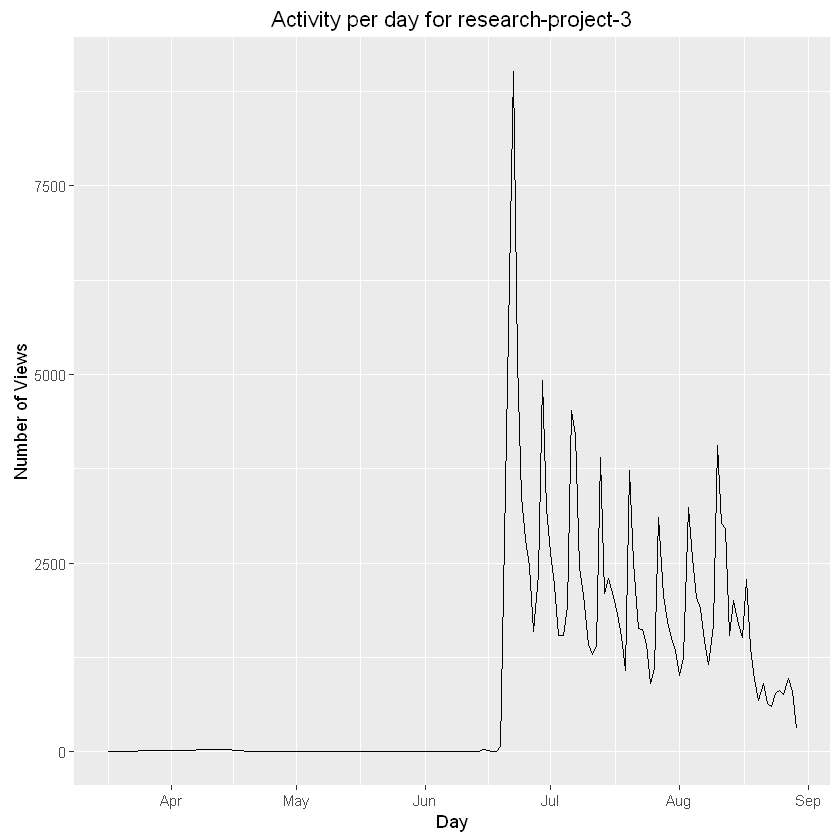

In [25]:
# This function plots the activity for a single course. This function receive the short_code as parameter.
plot_step_activity_daily("research-project-3")

In this chart it is possible to confirm the existence of cycles and how the peaks correspond to the number of weeks. However, it seems that there's some activity previous to the first day, suggesting that most likely there are administrative users preparing and reviewing the material before going live. Such activity may also be present after the course ends, but even if the data points are just few, those can distort some calculations and alter real activity ranges. To confirm this, the user ID and role are obtained using a date as reference.

In [26]:
# This function receive as parameter the course short code and a date in the format "yyyy-mm-dd"
get_user_role_activity_before("web-science-5", "2016-06-26")

,learner_id,role
1,071994c7-e216-4843-afa9-556e55412b59,organisation_admin
4,160aa78f-4397-439b-afc8-0f92d32f86dd,admin
7,29b98257-e174-4fa1-ab1c-e32b5c4030f8,admin
21,4a9531dc-2921-4596-a537-f6983e6397ce,organisation_admin
35,507fbfdc-e194-4b60-8c49-5a065587fa09,organisation_admin
49,5a5dc84f-7c95-4ac4-9c60-61a98ae12f7b,admin
60,ab429259-226f-4028-b4c4-4f58a3a20de7,admin
65,ed42eb87-3593-4935-9c45-d962e4248723,admin
79,ef36b469-a4f0-4139-8397-67edc3e667ba,organisation_admin


As suspected previously, it seems that the activity taking place before the beginning of the course belong to administrative roles. This confirms that such activity has to be removed and focus only in the learner role.

#### *Finding a Good Duration Reference*

The average duration is a value that is being analyzed in the following plot.

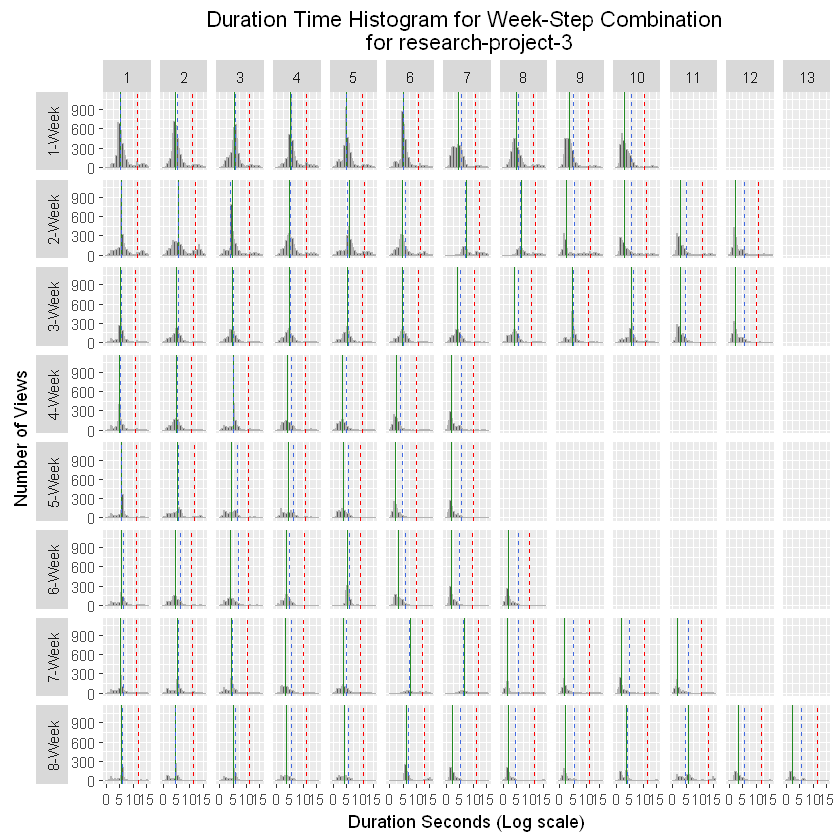

In [27]:
# This function plots the histogram of duration times per week-step combination. This function received the short_code as parameter
plot_weeks_steps_hist("research-project-3")

For most verified course short_codes, it was possible to establish that, due to the existence of big outlayers, **the most reasonable value to be considered as the reference duration is the median of measured visit length in seconds**. This value along with the estimated duration at course design will help getting an interesting picture about how accurate is such estimation, behaviors per content type, possible patterns according to content type, dropout points or symptoms, and if likely, estimate a reasonable criteria to define wheteher a user session starts and ends.
